In [57]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [58]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 

# data (as pandas dataframes) 
data = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets.values - 1

In [59]:
df=data[statlog_german_credit_data.variables.name[:-1]]
df_full=df.copy()
df_full.columns=statlog_german_credit_data.variables.description[:-1].to_list()
df_full

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


In [60]:
# Define preprocessing steps
numeric_features = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
binary_features = ['Attribute19', 'Attribute20']
categorical_features = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17']

# Apply LabelEncoder to binary features
label_encoders = {}
for feature in binary_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le  # Store the encoder for future use (e.g., inverse transform)

# Pipeline for numeric features: Imputation and Min-Max Scaling between -1 and 1
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Pipeline for categorical features: Imputation, OneHotEncoding, and Min-Max Scaling between -1 and 1
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),  # Set sparse=False for easy concatenation
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))  # Scaling the one-hot encoded features
])

# For binary features, use Min-Max Scaling as well
binary_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ]
)

# Apply the preprocessing steps to the DataFrame
df2 = preprocessor.fit_transform(df)

# If you want to convert it back to a DataFrame for ease of use
# Create column names for the one-hot encoded features
onehot_feature_names = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out())

# Combine all feature names
all_feature_names = numeric_features + onehot_feature_names + binary_features

# Create the processed DataFrame
df2 = pd.DataFrame(df2, columns=all_feature_names)

# Show the processed DataFrame
df2

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18,x0_A11,x0_A12,x0_A13,...,x8_A143,x9_A151,x9_A152,x9_A153,x10_A171,x10_A172,x10_A173,x10_A174,Attribute19,Attribute20
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,-1.0,1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,0.333333,1.000000,-0.571429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
996,-0.235294,-0.603059,1.000000,1.000000,-0.250000,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
997,-0.764706,-0.939034,1.000000,1.000000,-0.321429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
998,0.205882,-0.824475,1.000000,1.000000,-0.857143,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0


In [61]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)

class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha

        # Initialize A as identity matrices for each action
        self.A = [np.eye(context_dim) for _ in range(n_actions)]

        # Initialize b as zero arrays for each action
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]

    def update(self, action, reward, context):
        context = np.array(context)

        # Ensure context shape matches b[action]
        if context.shape != self.b[action].shape:
            raise ValueError(f"Context shape {context.shape} does not match expected shape {self.b[action].shape}")

        # Update A and b using outer product of context
        self.A[action] += np.outer(context, context)

        # Convert reward to a scalar if it's a zero-dimensional tensor
        if isinstance(reward, torch.Tensor) and reward.ndim == 0:
            reward = reward.item()

        # Now reward is guaranteed to be a scalar
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        preds = np.zeros((contexts.shape[0], self.n_actions))

        for i, context in enumerate(contexts):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = A_inv @ self.b[action]
                preds[i, action] = context @ theta + self.alpha * np.sqrt(context @ A_inv @ context.T)

        return preds

In [62]:
# RewardGenerator and generate_data functions (from your code)
class RewardGenerator:
    def __init__(self, drift_rate=0.005, seasonal_period=400):
        self.drift_rate = drift_rate
        self.seasonal_period = seasonal_period
        self.t = 0  # Initialize time step

    def generate_rewards(self, context, action, optimal_action, n=3):
        """
        Generates rewards with added complexity from context sampling and non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
        
        # Calculate reward based on action and non-stationary factors
        if action == optimal_action:
            mean = 1 + 0.2 * context_factor + time_drift + seasonality
            std = 0.1  # Small variance for optimal action
        else:
            mean = 0 + 0.5 * context_factor + time_drift + seasonality
            std = 0.4  # Higher variance for non-optimal action
        
        # Sample reward from Gaussian distribution
        reward = np.random.normal(mean, std)

        # Increment time step for next call
        self.t += 1
        
        return reward

    def generate_rewards_sigmoid(self, context, action, optimal_action, n=3):
        """
        Generates rewards using a sigmoid-based function for smooth reward scaling,
        incorporating drift and seasonality for non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
        
        # Sigmoid-based reward scaling
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        # Calculate base reward influenced by context and non-stationarity
        base_reward = 0.5 * context_factor + time_drift + seasonality
        
        # Apply sigmoid function to keep reward between 0 and 1
        scaled_reward = sigmoid(base_reward)
        
        # Modify reward based on whether the action is optimal or not
        if action == optimal_action:
            reward = 1 * scaled_reward  # High reward for optimal action
        else:
            reward = 0.5 * scaled_reward  # Reduced reward for non-optimal action
        
        # Increment time step for next call
        self.t += 1
        
        return reward
    
    def generate_rewards_logarithmic(self, context, action, optimal_action, n=3):
        """
        Generates rewards using a logarithmic-based function for diminishing returns scaling,
        incorporating drift and seasonality for non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = max(0, np.sum(sampled_context))
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
        
        # Logarithmic-based reward scaling
        base_reward = np.log(2 + context_factor)  # Use log(1+x) to avoid log(0) issues
        
        # Apply drift and seasonality to the reward
        base_reward = base_reward + time_drift + seasonality
        
        # Modify reward based on whether the action is optimal or not
        if action == optimal_action:
            reward = 1 + 0.2 * base_reward  # High reward for optimal action
        else:
            reward = 0.2 * base_reward  # Reduced reward for non-optimal action
        
        # Increment time step for next call
        self.t += 1
        
        return reward




# Example usage in your data generation function
def generate_data(context, total_samples, n_actions, optimal_actions, reward_type):
    rewards = torch.zeros(total_samples, n_actions)
    
    reward_gen = RewardGenerator()

    for i in range(total_samples):
        for action in range(n_actions):
            # Generate rewards based on the given logic
            if reward_type == 'linear':
                rewards[i, action] = reward_gen.generate_rewards(context[i], action,  optimal_actions[i])
            elif reward_type == 'sigmoid':
                rewards[i, action] = reward_gen.generate_rewards_sigmoid(context[i], action,  optimal_actions[i])
            elif reward_type == 'log':
                rewards[i, action] = reward_gen.generate_rewards_logarithmic(context[i], action,  optimal_actions[i])

    return rewards


# Function to generate actions from a normal distribution and clip them to valid action range
def generate_actions(total_samples):
    return  np.random.choice([0, 1], size=total_samples)

# Define the data generation and splitting function
def generate_data_and_split(X, total_samples, n_actions, optimal_actions, reward_type):
    
    rewards=generate_data(X, total_samples, n_actions, optimal_actions, reward_type)
    split_index = int(total_samples * 0.9)
    X_train = X[:split_index]
    historical_actions = generate_actions(split_index)
    historical_rewards = rewards[:split_index]
    
    X_val = X[split_index:]
    optimal_actions_val = optimal_actions[split_index:]
    rewards_val = rewards[split_index:]
    
    return X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val

In [63]:
def plot_optimal_vs_linucb(optimal_actions, linucb_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(linucb_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(linucb_actions, bins=bins, edgecolor='black', alpha=0.5, label='LinUCB Actions')
    
    plt.title('Comparison of Optimal Actions vs LinUCB Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [64]:
def run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, reward_type = 'linear', num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20):
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
       X, total_samples, n_actions, optimal_actions, reward_type)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()
    
    # LinUCB
    lin_UCB_model = LinUCB(n_actions, context_dim, alpha=0.5)
    for i in range(len(historical_actions)):
        lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])

    lin_UCB_preds = lin_UCB_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
    

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    
    reward_gen = RewardGenerator()
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            if reward_type == 'linear':
                all_true_rewards[i, action] =  reward_gen.generate_rewards(X_val[i], action, opt_action)
            elif reward_type == 'sigmoid':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_sigmoid(X_val[i], action, opt_action)
            elif reward_type == 'log':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_logarithmic(X_val[i], action, opt_action)
        

    true_rewards = np.max(all_true_rewards, axis=1)
    
    lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(lin_UCB_rewards), label='Lin_UCB Strategy')
    
  
    plt.title(f'Cumulative Rewards with {reward_type} reward')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)
    
    print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")


In [65]:
# Example usage
X=df2.values
total_samples = X.shape[0]
n_actions = 2
context_dim =X.shape[1]   # Number of context features
optimal_actions=y

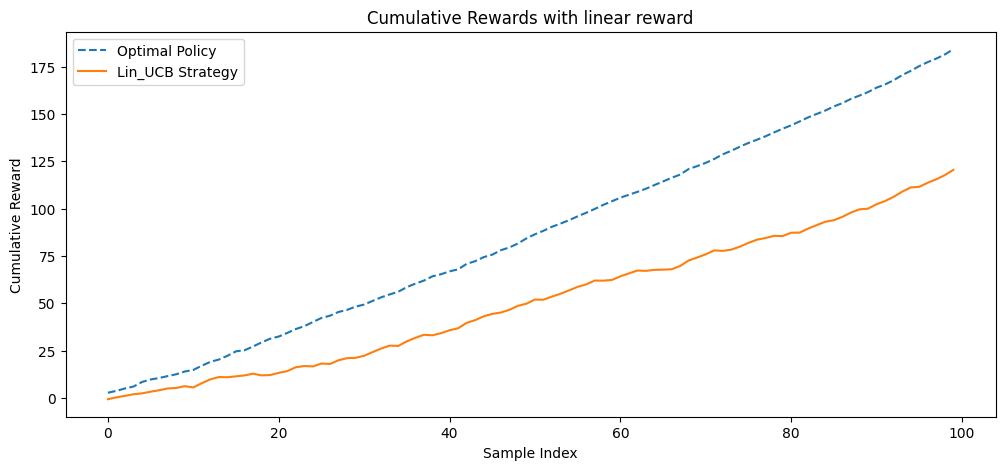

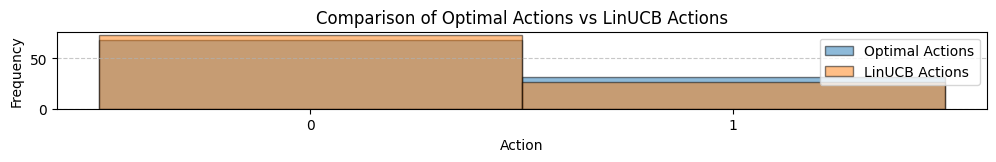

LinUCB Accuracy: 0.6100
LinUCB F1 Score: 0.6004


In [66]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, reward_type = 'linear', num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)

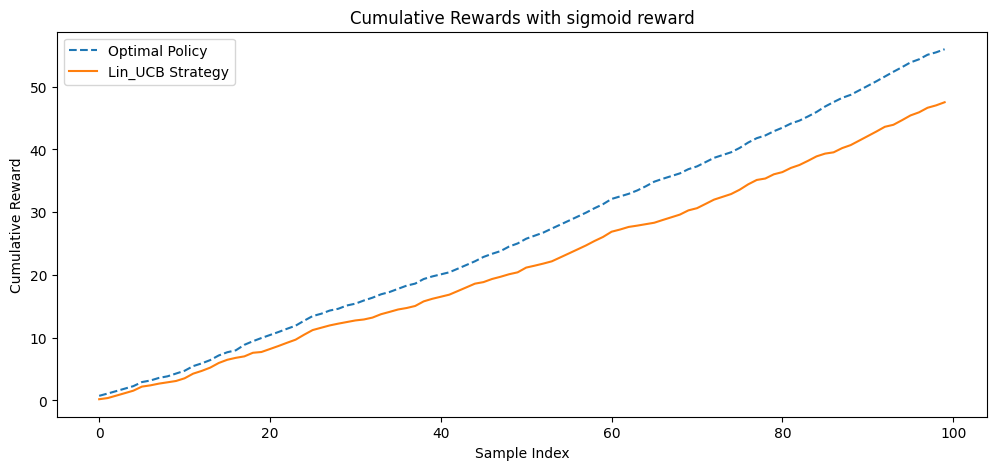

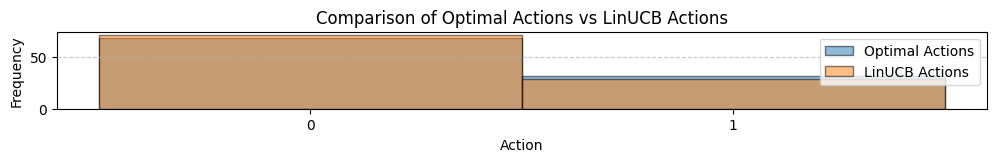

LinUCB Accuracy: 0.7100
LinUCB F1 Score: 0.7060


In [67]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, reward_type = 'sigmoid', num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)

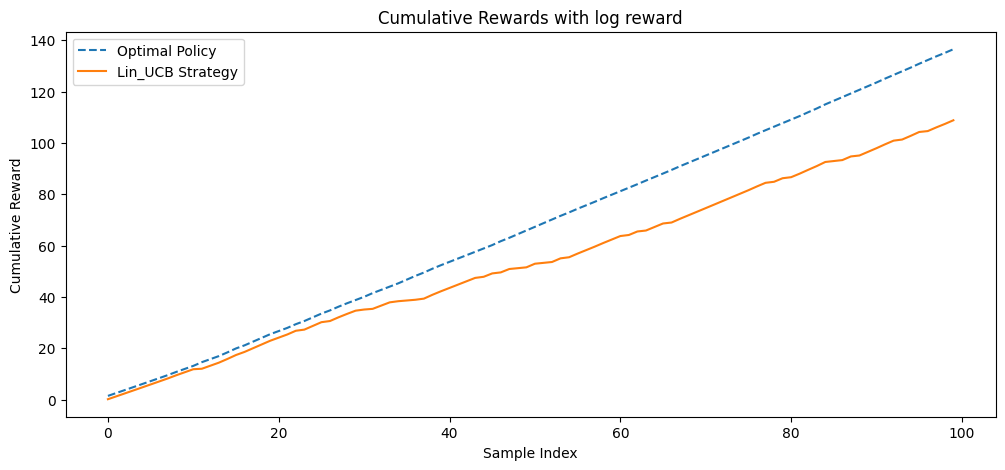

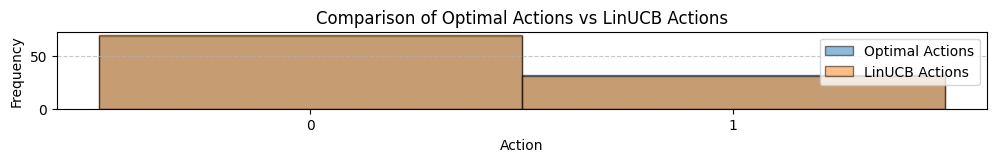

LinUCB Accuracy: 0.7300
LinUCB F1 Score: 0.7288


In [68]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, reward_type = 'log', num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)

In [69]:
def run_backtest_with_alpha(X, total_samples, n_actions, optimal_actions, context_dim, reward_type='linear', alpha_values=[0.1, 0.5, 1.0], epochs=20):
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        X, total_samples, n_actions, optimal_actions, reward_type)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()
    
    # Initialize reward generator for the test set
    reward_gen = RewardGenerator()

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            if reward_type == 'linear':
                all_true_rewards[i, action] =  reward_gen.generate_rewards(X_val[i], action, opt_action)
            elif reward_type == 'sigmoid':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_sigmoid(X_val[i], action, opt_action)
            elif reward_type == 'log':
                all_true_rewards[i, action] =  reward_gen.generate_rewards_logarithmic(X_val[i], action, opt_action)
            
    true_rewards = np.max(all_true_rewards, axis=1)
    
    # Plot cumulative rewards for each alpha
    plt.figure(figsize=(12, 6))
    
    for alpha in alpha_values:
        # LinUCB with different alphas
        lin_UCB_model = LinUCB(n_actions, context_dim, alpha=alpha)
        
        # Train LinUCB model
        for i in range(len(historical_actions)):
            lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
        
        # Predict with LinUCB on validation set
        lin_UCB_preds = lin_UCB_model.predict(X_val)
        lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
        
        # Calculate rewards from LinUCB strategy
        lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
        
        # Plot cumulative rewards for this alpha
        plt.plot(np.cumsum(lin_UCB_rewards), label=f'LinUCB (alpha={alpha})')

    # Plot cumulative rewards of the optimal policy
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--', color='black')
    
    plt.title(f'Cumulative Rewards with {reward_type} reward')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy and F1 score for the final comparison (optional)
    for alpha in alpha_values:
        lin_UCB_model = LinUCB(n_actions, context_dim, alpha=alpha)
        for i in range(len(historical_actions)):
            lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
        
        lin_UCB_preds = lin_UCB_model.predict(X_val)
        lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
        
        print(f"Alpha: {alpha}")
        print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
        print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")
        print("\n")

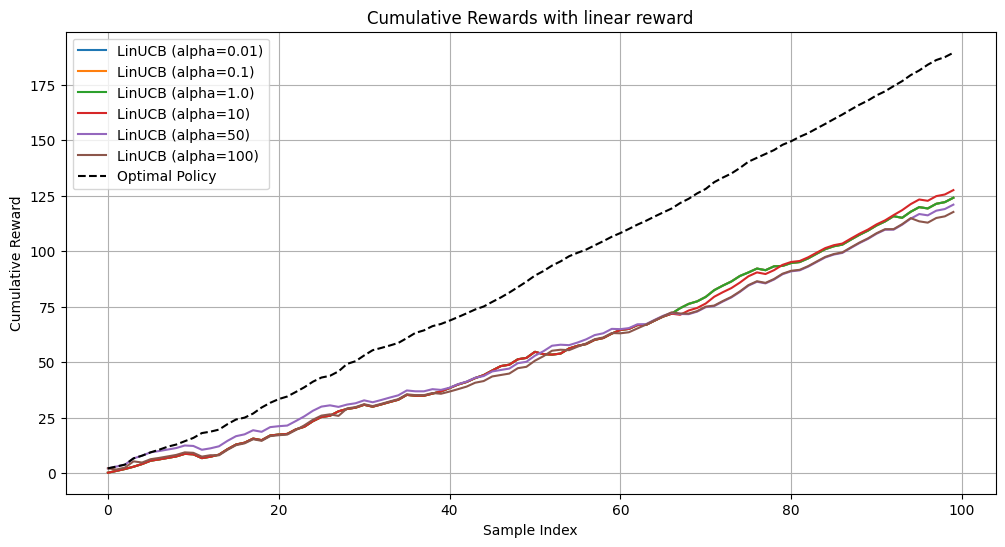

Alpha: 0.01
LinUCB Accuracy: 0.6100
LinUCB F1 Score: 0.6167


Alpha: 0.1
LinUCB Accuracy: 0.6100
LinUCB F1 Score: 0.6167


Alpha: 1.0
LinUCB Accuracy: 0.6100
LinUCB F1 Score: 0.6167


Alpha: 10
LinUCB Accuracy: 0.6300
LinUCB F1 Score: 0.6363


Alpha: 50
LinUCB Accuracy: 0.5500
LinUCB F1 Score: 0.5648


Alpha: 100
LinUCB Accuracy: 0.5200
LinUCB F1 Score: 0.5351




In [70]:
alpha_values = [0.01, 0.1, 1.0, 10, 50, 100]
run_backtest_with_alpha(X, total_samples=1000, n_actions=2, optimal_actions=optimal_actions, context_dim=X.shape[1], reward_type='linear', alpha_values=alpha_values)